### Skin penetration by nanoparticles

#### Importing the libraries

In [1]:
library(openxlsx)
library(ggplot2)
library(egg)
library(GGally)
library(Rtsne)
library(FactoMineR)
library(factoextra)

Loading required package: gridExtra
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


#### Importing the data

In [2]:
method_file_name = "som"
data_file_path = paste("data/",method_file_name,".xlsx",sep="")

train_df <- read.xlsx(data_file_path, sheet = 1) # training dataset
validation_df <- read.xlsx(data_file_path, sheet = 2) # validation dataset
test_df <- read.xlsx(data_file_path, sheet = 3) # testing dataset


#features names
features <- colnames(train_df)[-ncol(train_df)]
#labels
label <- colnames(train_df)[ncol(train_df)-1]
labelQ <- colnames(train_df)[ncol(train_df)]

#removing the duplicate column
train_df[label] <- NULL
validation_df[label] <- NULL
test_df[label] <- NULL

features <- colnames(train_df)[-ncol(train_df)]
#changing the label character to factor
train_df[labelQ] <- as.factor(train_df[,labelQ])
validation_df[labelQ] <- as.factor(validation_df[,labelQ])
test_df[labelQ] <- as.factor(test_df[,labelQ])

head(train_df)
head(validation_df)
head(test_df)

Conc,SA,V,SA/V,Th-SC,Th-Ep,Th-T,Fol-Den,Fol-Dia,Enh,Kow,ConAng,Kow-sw,ConAng-sw,LayerQ
15.8547179,1256.637,4188.79,0.3000000,15.00,67.5,2.48,264.8,97,0,0.00,72,0,1,A
0.1268377,31415.927,523598.78,0.0600000,15.00,67.5,2.48,264.8,97,0,0.00,72,0,1,A
3.9636795,3298.672,41887.90,0.0787500,17.80,61.1,2.54,11.0,200,0,0.00,72,0,1,A
9.4000000,4300.840,26521.85,0.1621622,8.90,28.6,0.70,365.5,36,0,-1.16,0,1,0,B
0.2830662,10838.495,70685.83,0.1533333,17.80,61.1,2.54,11.0,117,0,0.00,25,0,1,B
1.0000000,4901.670,32269.33,0.1518987,17.82,61.1,2.54,11.0,117,0,-1.16,0,1,0,B


Conc,SA,V,SA/V,Th-SC,Th-Ep,Th-T,Fol-Den,Fol-Dia,Enh,Kow,ConAng,Kow-sw,ConAng-sw,LayerQ
1.268377e-01,31415.927,523598.776,0.0600000,15.00000,67.50000,2.48000,264.8000,97,0,0,72,0,1,A
1.283477e-07,1256.637,4188.790,0.3000000,17.82125,61.10000,2.54742,11.0000,117,0,0,75,0,1,A
1.767606e+00,5026.548,33510.322,0.1500000,15.58889,67.54286,2.48000,264.8333,97,0,0,151,0,1,B
1.693880e+00,2042.035,25132.741,0.0812500,17.82125,61.10000,2.54742,11.0000,117,0,0,90,0,1,B
7.642787e-02,8835.729,261799.388,0.0337500,17.80000,61.10000,2.54000,11.0000,117,0,0,25,0,1,B
1.804133e+01,2123.717,9202.772,0.2307692,17.80000,61.10000,2.54000,11.0000,117,0,0,139,0,1,B


Conc,SA,V,SA/V,Th-SC,Th-Ep,Th-T,Fol-Den,Fol-Dia,Enh,Kow,ConAng,Kow-sw,ConAng-sw,LayerQ
7.3957868,3848.4510,22449.29750,0.1714286,17.80000,61.10000,2.54,11.0000,200,0,0.00,72,0,1,A
33.5190452,706.8583,1767.14587,0.4000000,15.58889,67.54286,2.48,264.8333,97,0,0.00,151,0,1,B
10.0000000,4901.6699,32269.32709,0.1518987,17.82000,61.10000,2.54,11.0000,117,0,-1.16,0,1,0,B
1.0000000,66.4761,50.96501,1.3043478,16.60000,32.00000,2.09,289.0000,25,0,-1.16,0,1,0,B
2.5367549,7853.9816,65449.84695,0.1200000,17.80000,61.10000,2.54,11.0000,117,0,0.00,72,0,1,B
0.5661324,6126.1057,35342.91735,0.1733333,17.80000,61.10000,2.54,11.0000,117,0,0.00,25,0,1,B


#### Checking for duplicated entries

In [3]:
counts <- data.frame(
           train=c(nrow(train_df),nrow(unique(train_df))),
           validation=c(nrow(validation_df),nrow(unique(validation_df))),
           test=c(nrow(test_df),nrow(unique(test_df))))

rownames(counts) <- c("nrow(df)","nrow(unique(df))")
counts

,train,validation,test
nrow(df),265,30,32
nrow(unique(df)),98,29,31


#### Checking if all datasets have the same columns

In [4]:
(colnames(train_df) == colnames(validation_df)) && (colnames(train_df) == colnames(test_df))
#double check
colnames(train_df)
colnames(validation_df)
colnames(test_df)

[1] TRUE

[1] "Conc"      "SA"        "V"         "SA/V"      "Th-SC"     "Th-Ep"    
 [7] "Th-T"      "Fol-Den"   "Fol-Dia"   "Enh"       "Kow"       "ConAng"   
[13] "Kow-sw"    "ConAng-sw" "LayerQ"

[1] "Conc"      "SA"        "V"         "SA/V"      "Th-SC"     "Th-Ep"    
 [7] "Th-T"      "Fol-Den"   "Fol-Dia"   "Enh"       "Kow"       "ConAng"   
[13] "Kow-sw"    "ConAng-sw" "LayerQ"

[1] "Conc"      "SA"        "V"         "SA/V"      "Th-SC"     "Th-Ep"    
 [7] "Th-T"      "Fol-Den"   "Fol-Dia"   "Enh"       "Kow"       "ConAng"   
[13] "Kow-sw"    "ConAng-sw" "LayerQ"

#### Checking the distribution of classes in the dataset

[1] "training set"


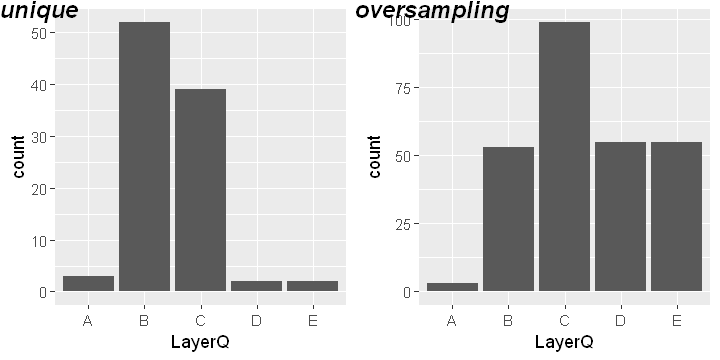

[1] "validation set"


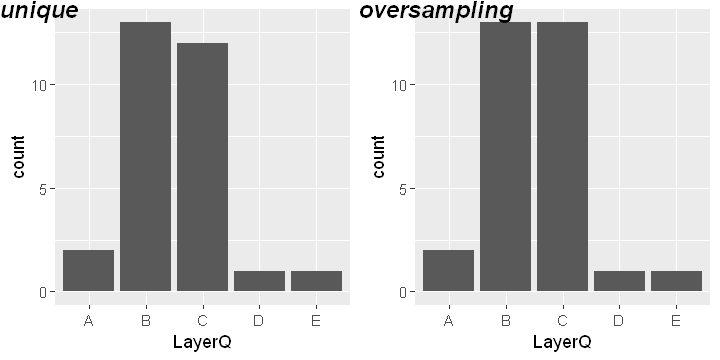

[1] "testing set"


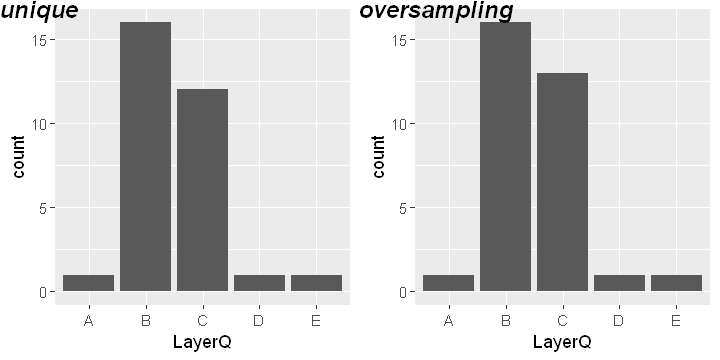

In [5]:
options(repr.plot.width = 6, repr.plot.height = 3)

ggarrange(ggplot(data = unique(train_df),aes(x = LayerQ)) + geom_bar(),
          ggplot(data = train_df,aes(x = LayerQ)) + geom_bar(), # the set is balanced by oversampling
          labels = c("unique", "oversampling"),
          ncol = 2, nrow = 1)
print("training set")
ggarrange(ggplot(data = unique(validation_df),aes(x = LayerQ)) + geom_bar(),
          ggplot(data = validation_df,aes(x = LayerQ)) + geom_bar(), # the set is balanced by oversampling
          labels = c("unique", "oversampling"),
          ncol = 2, nrow = 1)
print("validation set")
ggarrange(ggplot(data = unique(test_df),aes(x = LayerQ)) + geom_bar(),
          ggplot(data = test_df,aes(x = LayerQ)) + geom_bar(), # the set is balanced by oversampling
          labels = c("unique", "oversampling"),
          ncol = 2, nrow = 1)
print("testing set")

#### Simple analysis of the data (whole dataset)

In [6]:
all_df = unique(rbind(train_df,validation_df,test_df))
summary(all_df)
head(all_df)

      Conc                SA                  V                SA/V       
 Min.   :     0.0   Min.   :    50.27   Min.   :     34   Min.   :0.0300  
 1st Qu.:     0.7   1st Qu.:  1256.64   1st Qu.:   4189   1st Qu.:0.1276  
 Median :     2.4   Median :  3848.45   Median :  22089   Median :0.2000  
 Mean   :  2634.2   Mean   :  8462.81   Mean   : 137066   Mean   :0.2963  
 3rd Qu.:     8.1   3rd Qu.:  8465.02   3rd Qu.:  70686   3rd Qu.:0.3000  
 Max.   :388879.3   Max.   :125663.71   Max.   :4188790   Max.   :1.5000  
     Th-SC           Th-Ep            Th-T          Fol-Den     
 Min.   : 6.18   Min.   :11.73   Min.   :0.700   Min.   :  0.0  
 1st Qu.:15.00   1st Qu.:61.10   1st Qu.:2.480   1st Qu.: 11.0  
 Median :15.59   Median :61.10   Median :2.540   Median : 11.0  
 Mean   :15.98   Mean   :59.77   Mean   :2.436   Mean   :107.5  
 3rd Qu.:17.80   3rd Qu.:67.50   3rd Qu.:2.540   3rd Qu.:264.8  
 Max.   :17.82   Max.   :67.54   Max.   :2.547   Max.   :366.5  
    Fol-Dia         

Conc,SA,V,SA/V,Th-SC,Th-Ep,Th-T,Fol-Den,Fol-Dia,Enh,Kow,ConAng,Kow-sw,ConAng-sw,LayerQ
15.8547179,1256.637,4188.79,0.3000000,15.00,67.5,2.48,264.8,97,0,0.00,72,0,1,A
0.1268377,31415.927,523598.78,0.0600000,15.00,67.5,2.48,264.8,97,0,0.00,72,0,1,A
3.9636795,3298.672,41887.90,0.0787500,17.80,61.1,2.54,11.0,200,0,0.00,72,0,1,A
9.4000000,4300.840,26521.85,0.1621622,8.90,28.6,0.70,365.5,36,0,-1.16,0,1,0,B
0.2830662,10838.495,70685.83,0.1533333,17.80,61.1,2.54,11.0,117,0,0.00,25,0,1,B
1.0000000,4901.670,32269.33,0.1518987,17.82,61.1,2.54,11.0,117,0,-1.16,0,1,0,B


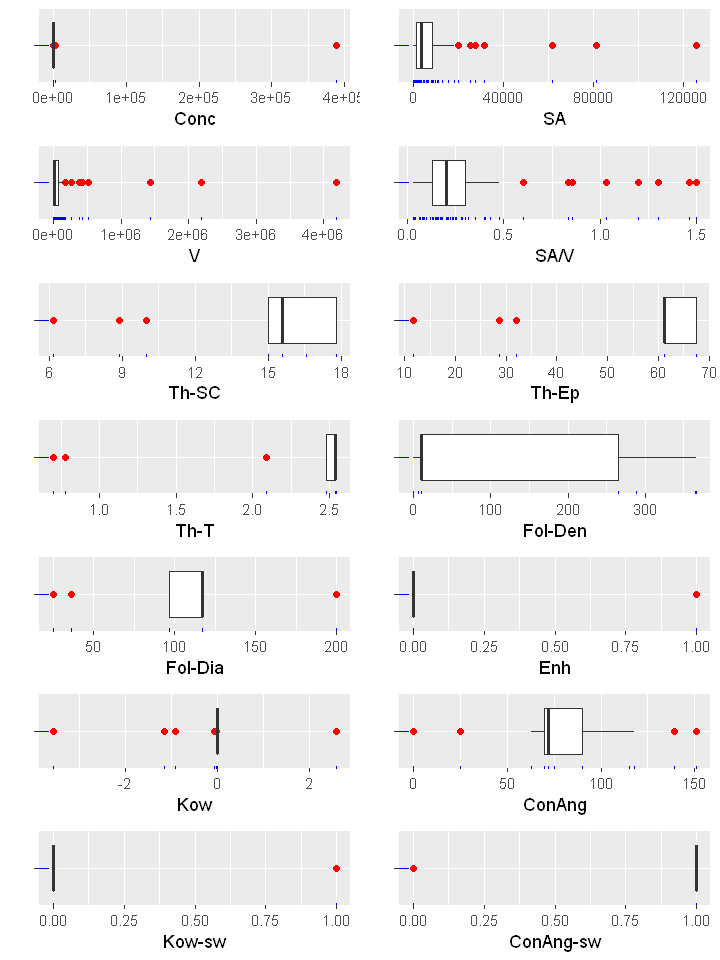

In [7]:
options(repr.plot.width=6, repr.plot.height =8)
colN <- ncol(all_df)
boxList <- sapply(names(all_df[-colN]), function(col) {
        ggplot(data = all_df,aes(x = "", y = all_df[,col] )) + geom_boxplot(outlier.colour="red") + coord_flip() + 
        geom_rug(colour="blue") + ylab(col) + xlab("")
}, simplify=FALSE)
grid.arrange(grobs = boxList, ncol=2)

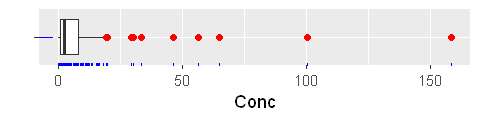

In [8]:
# box plot for Conc with removed very far outliers
options(repr.plot.width=4, repr.plot.height =1)
ggplot(data = all_df[all_df$Conc<500,],aes(x = "", y = Conc )) + geom_boxplot(outlier.colour="red") + coord_flip() + 
        geom_rug(colour="blue") + ylab("Conc") + xlab("")

#### Trying to figure out how sparse the data is

In [9]:
ue <- data.frame(lapply(all_df,function(c) length(unique(c))))
rownames(ue) <- c("unique elements")
ue

,Conc,SA,V,SA.V,Th.SC,Th.Ep,Th.T,Fol.Den,Fol.Dia,Enh,Kow,ConAng,Kow.sw,ConAng.sw,LayerQ
unique elements,121,58,61,62,11,8,6,8,5,2,7,11,2,2,5


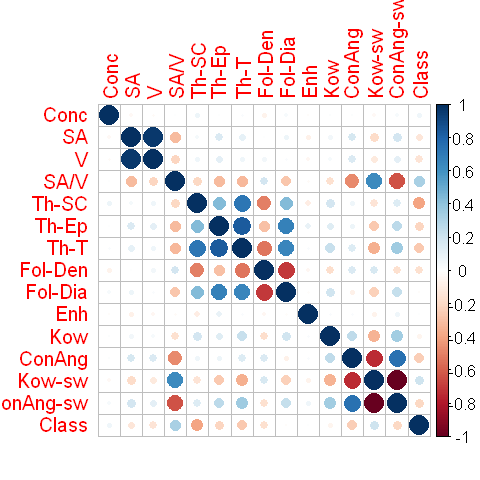

In [37]:
options(repr.plot.width=4, repr.plot.height=4)
tmp.df <- cbind(all_df[-ncol(all_df)],as.numeric(factor(all_df[[ncol(all_df)]])))
colnames(tmp.df)[ncol(tmp.df)] <- "Class"
corrplot::corrplot(cor(tmp.df))

#### t-SNE

It can be noticed, that among particular groups different factors influence the skin layer to which the particles will penetrate. This is clearly visible for group B

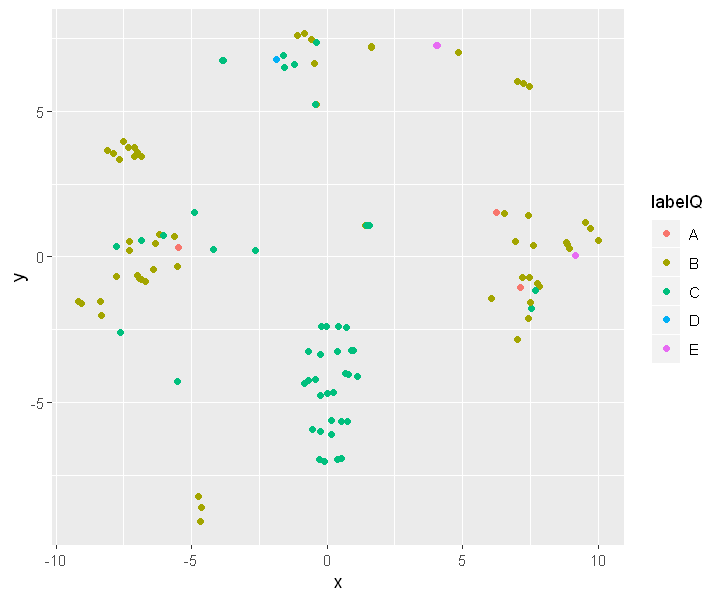

In [54]:
d <- duplicated(all_df[,features])
tsne_result2 <- Rtsne(all_df[!d,features], dims=2, perplexity=30, verbose=FALSE, max_iter = 10000, theta = 0.0, eta = 100,
                      pca_scale = TRUE, normalize = FALSE, pca_center = TRUE)
tsne_df2 <- data.frame(x = tsne_result2$Y[,1],y=tsne_result2$Y[,2],labelQ = all_df[!d,labelQ])
options(repr.plot.width=6, repr.plot.height = 5)
ggplot(data = tsne_df2, aes(x=x,y=y,col=labelQ)) + geom_point()

#### Linear PCA

In [56]:
pca_transformation <- prcomp(all_df[!d,features],center = TRUE,  scale = TRUE, rank. = 7)

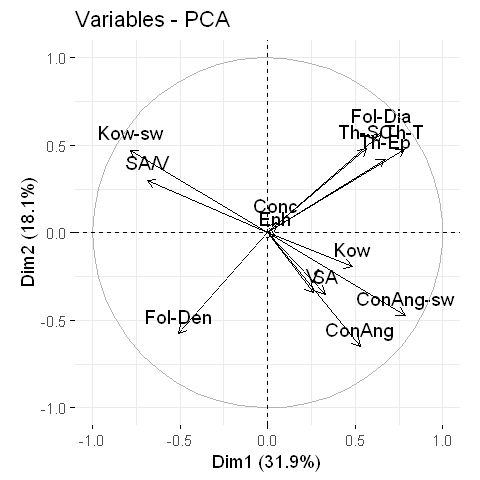

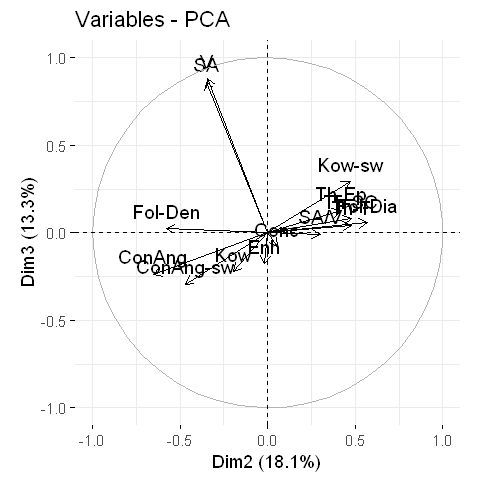

In [58]:
options(repr.plot.width=4, repr.plot.height =4)
fviz_pca_var(pca_transformation,axes = c(1, 2))
fviz_pca_var(pca_transformation,axes = c(2, 3))

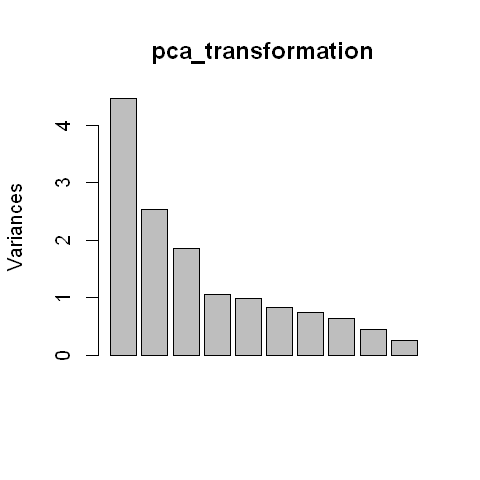

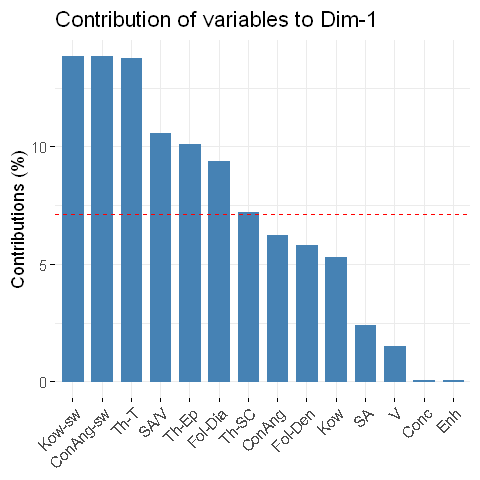

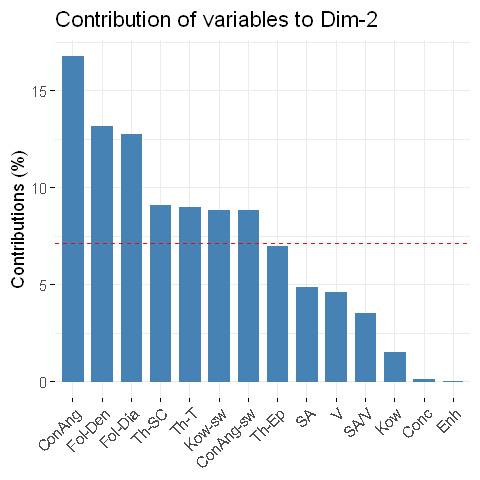

In [59]:
screeplot(pca_transformation)
fviz_contrib(pca_transformation,choice="var",axes=1)
fviz_contrib(pca_transformation,choice="var",axes=2)

#### Checking wether removing $Conc$ outlier will influence the PCA (not really)

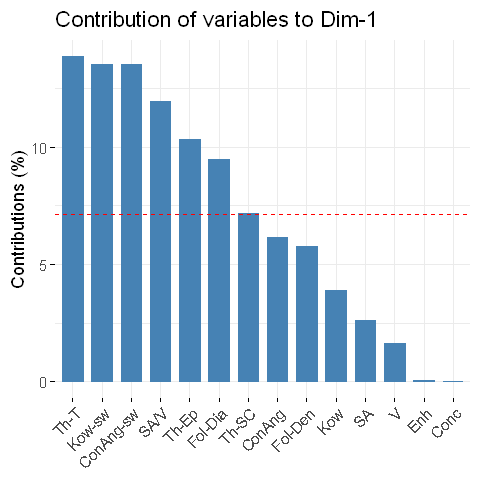

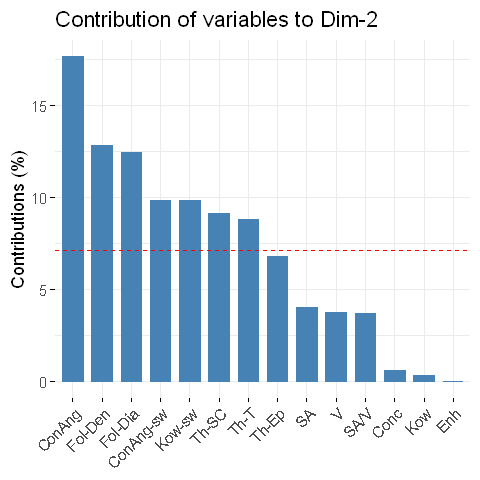

In [60]:
pca_transformation <- prcomp(all_df[all_df$Conc<500,features],center = TRUE,  scale = TRUE, rank. = 7)
fviz_contrib(pca_transformation,choice="var",axes=1)
fviz_contrib(pca_transformation,choice="var",axes=2)